# Reference CHEMBL library

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.inchi import MolToInchiKey
from rdkit import RDLogger
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Silence RDKit noise
RDLogger.DisableLog("rdApp.*")

%matplotlib inline


# Deduplication

In [2]:
chembl_sdf_path='chembl_36.sdf'
dedup_sdf_path='chembl_dedup.sdf'
n_bins=60

In [ ]:
# RDKit standardization helpers
lfc = rdMolStandardize.LargestFragmentChooser()
normalizer = rdMolStandardize.Normalizer()
uncharger = rdMolStandardize.Uncharger()

def standardize_and_get_inchikey(mol, strip_stereo=True):
    """
    Standardize a molecule, optionally strip stereochemistry, and get:
      - standardized Mol
      - InChIKey (dedup key)
      - canonical SMILES (for convenience, not for dedup)

    Returns (mol_clean, inchikey, smiles) or (None, None, None).
    """
    if mol is None:
        return None, None, None

    try:
        # Largest fragment (remove salts/solvents, keep main species)
        mol = lfc.choose(mol)

        # Cleanup + normalize + uncharge
        mol = rdMolStandardize.Cleanup(mol)
        mol = normalizer.normalize(mol)
        mol = uncharger.uncharge(mol)

        # Sanitize structure
        Chem.SanitizeMol(mol)

        # Optionally collapse stereochemistry to avoid stereo-duplicated entries
        if strip_stereo:
            Chem.RemoveStereochemistry(mol)

        # InChIKey **after** standardization 
        ik = MolToInchiKey(mol)

        # Canonical SMILES 
        smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=not strip_stereo)

        # Rebuild from SMILES to have a clean canonical representation
        mol_clean = Chem.MolFromSmiles(smiles)
        if mol_clean is None:
            return None, None, None
        Chem.SanitizeMol(mol_clean)

        return mol_clean, ik, smiles

    except Exception:
        return None, None, None

In [4]:
supplier = Chem.SDMolSupplier(chembl_sdf_path, sanitize=False, removeHs=True)
writer = Chem.SDWriter(dedup_sdf_path)

seen_inchikeys = set()
rows = []

total = 0
invalid = 0
duplicates = 0
written = 0

for mol in tqdm(supplier, desc="Cleaning and deduplicating (InChIKey)"):
    total += 1

    mol_clean, ik, smi = standardize_and_get_inchikey(mol, strip_stereo=True)
    if mol_clean is None or ik is None:
        invalid += 1
        continue

    if ik in seen_inchikeys:
        duplicates += 1
        continue

    seen_inchikeys.add(ik)
    writer.write(mol_clean)
    written += 1

    mw = Descriptors.MolWt(mol_clean)
    hacc = rdMolDescriptors.CalcNumHBA(mol_clean)
    rows.append((smi, ik, mw, hacc))

writer.close()

print("=== Summary ===")
print(f"Total molecules read        : {total}")
print(f"Invalid / failed molecules  : {invalid}")
print(f"Duplicate InChIKeys         : {duplicates}")
print(f"Unique molecules written    : {written}")
print(f"Distinct InChIKeys stored   : {len(seen_inchikeys)}")

Cleaning and deduplicating (InChIKey):   0%|          | 0/2854815 [00:00<?, ?it/s]

=== Summary ===
Total molecules read        : 2854815
Invalid / failed molecules  : 0
Duplicate InChIKeys         : 241545
Unique molecules written    : 2613270
Distinct InChIKeys stored   : 2613270


In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
import pandas as pdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
%matplotlib inline

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


## Property Filtering

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen
from tqdm import tqdm
import csv

sdf_in_path = "chembl_dedup.sdf"
csv_out_path = "chembl_dedup_props.csv"

supplier = Chem.SDMolSupplier(sdf_in_path, sanitize=True, removeHs=True)

with open(csv_out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "SMILES",
        "MW",
        "HeavyAtomCount",
        "RingCount",
        "LogP",
        "HBD",
        "HBA",
        "RotatableBonds"
    ])

    total = 0
    invalid = 0

    for mol in tqdm(supplier, desc="Extracting MW, HA, Rings, LogP, HBD, HBA, RB"):
        total += 1

        if mol is None:
            invalid += 1
            continue

        try:
            smi = Chem.MolToSmiles(mol, canonical=True)
            mw = Descriptors.MolWt(mol)
            ha = mol.GetNumHeavyAtoms()
            rings = rdMolDescriptors.CalcNumRings(mol)

            logp = Crippen.MolLogP(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            rb = rdMolDescriptors.CalcNumRotatableBonds(mol)

        except Exception:
            invalid += 1
            continue

        writer.writerow([smi, mw, ha, rings, logp, hbd, hba, rb])

print("Done.")
print("Invalid molecules:", invalid)


Extracting MW, HA, Rings, LogP, HBD, HBA, RB: 100%|██████████| 2613270/2613270 [25:44<00:00, 1692.22it/s]

Done.
Invalid molecules: 0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

csv_out_path = "chembl_dedup_props.csv"

# Columns we want to extract
usecols = [
    "MW",
    "HeavyAtomCount",
    "RingCount",
    "LogP",
    "HBD",
    "HBA",
    "RotatableBonds"
]

df = pd.read_csv(csv_out_path, usecols=usecols)

# === Compute min/max for each property ===
mw_min, mw_max = df["MW"].min(), df["MW"].max()
ha_min, ha_max = df["HeavyAtomCount"].min(), df["HeavyAtomCount"].max()
r_min,  r_max  = df["RingCount"].min(), df["RingCount"].max()
logp_min, logp_max = df["LogP"].min(), df["LogP"].max()
hbd_min, hbd_max = df["HBD"].min(), df["HBD"].max()
hba_min, hba_max = df["HBA"].min(), df["HBA"].max()
rb_min, rb_max = df["RotatableBonds"].min(), df["RotatableBonds"].max()

(mw_min, mw_max,
 ha_min, ha_max,
 r_min, r_max,
 logp_min, logp_max,
 hbd_min, hbd_max,
 hba_min, hba_max,
 rb_min, rb_max)


(4.003,
 10188.533999999972,
 1,
 681,
 0,
 85,
 -63.92089999999894,
 101.83020000000111,
 0,
 131,
 0,
 276,
 0,
 316)

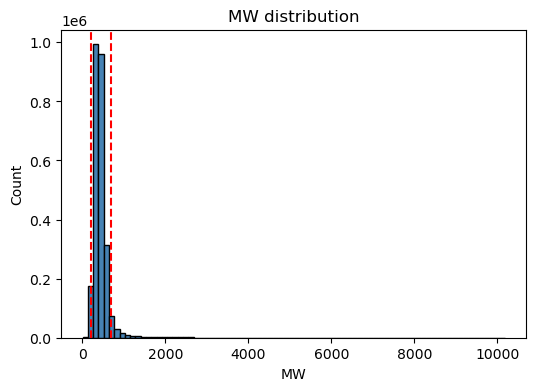

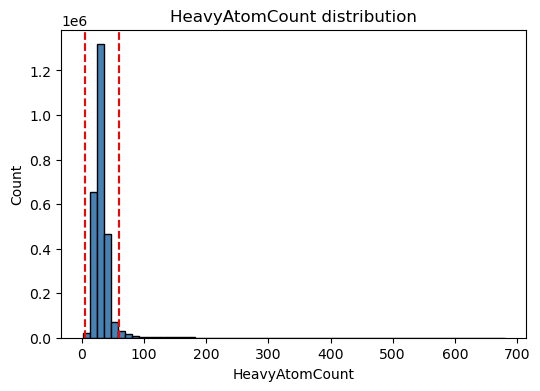

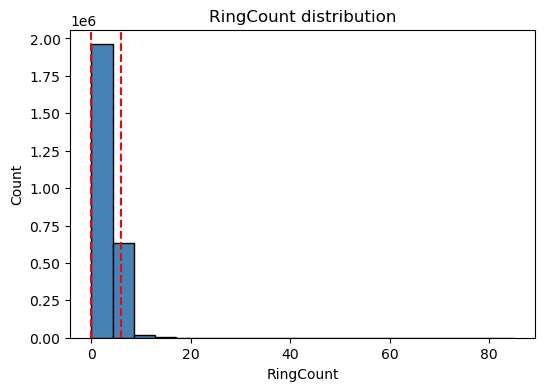

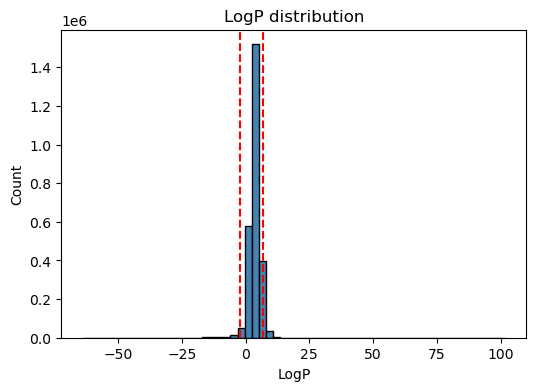

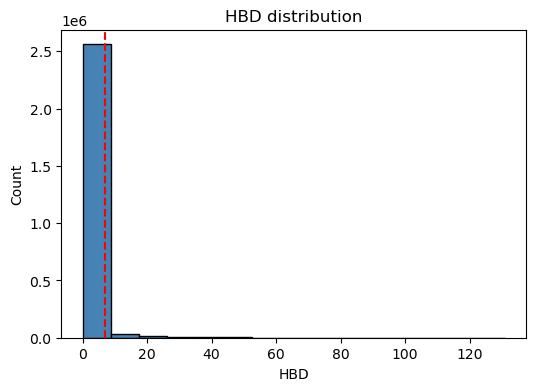

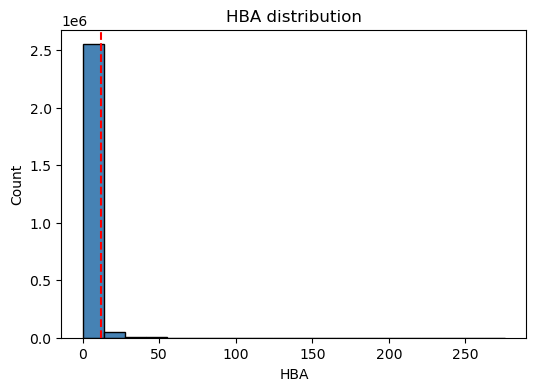

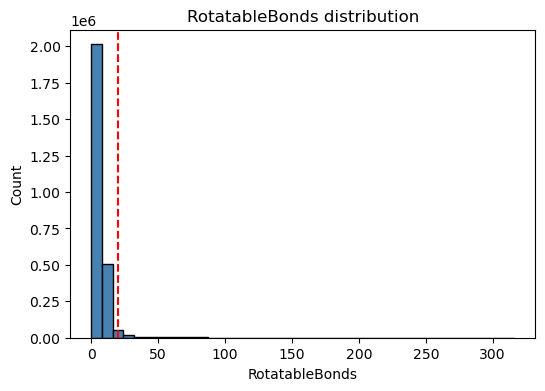

In [5]:
import matplotlib.pyplot as plt

# === Proposed thresholds (adjust later) ===
MIN_MW,  MAX_MW  = 200, 700
MIN_HA,  MAX_HA  = 5, 60
MIN_RINGS, MAX_RINGS = 0, 6

MIN_LOGP, MAX_LOGP = -2, 7
MAX_HBD = 7
MAX_HBA = 12
MAX_RB  = 20

# Helper function for uniform plotting
def plot_property(df, col, bins, min_val=None, max_val=None):
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=bins, color="steelblue", edgecolor="black")
    
    if min_val is not None:
        plt.axvline(min_val, color="red", linestyle="--")
    if max_val is not None:
        plt.axvline(max_val, color="red", linestyle="--")
    
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# === MW ===
plot_property(df, "MW", bins=80, min_val=MIN_MW, max_val=MAX_MW)

# === Heavy Atom Count ===
plot_property(df, "HeavyAtomCount", bins=60, min_val=MIN_HA, max_val=MAX_HA)

# === Ring Count ===
plot_property(df, "RingCount", bins=20, min_val=MIN_RINGS, max_val=MAX_RINGS)

# === LogP ===
plot_property(df, "LogP", bins=60, min_val=MIN_LOGP, max_val=MAX_LOGP)

# === HBD ===
plot_property(df, "HBD", bins=15, max_val=MAX_HBD)

# === HBA ===
plot_property(df, "HBA", bins=20, max_val=MAX_HBA)

# === Rotatable Bonds ===
plot_property(df, "RotatableBonds", bins=40, max_val=MAX_RB)


In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from tqdm import tqdm
import csv

sdf_in_path = "chembl_dedup.sdf"                 # current deduped set
sdf_out_path = "chembl_filtered_2.sdf"             # filtered SDF
csv_out_path = "chembl_filtered_props_2.csv"       # filtered props

# Thresholds
MIN_MW, MAX_MW = 200, 700
MIN_HEAVY, MAX_HEAVY = 5, 60
MIN_RINGS, MAX_RINGS = 0, 6
MIN_LOGP = -2
MAX_LOGP = 7
MAX_HBD = 7
MAX_HBA = 12
MAX_RB  = 20


In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen
import csv
from tqdm.auto import tqdm

supplier = Chem.SDMolSupplier(sdf_in_path, sanitize=True, removeHs=True)
writer = Chem.SDWriter(sdf_out_path)

total = 0
invalid = 0
kept = 0
filtered_out = 0

with open(csv_out_path, "w", newline="") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow([
        "SMILES", "MW", "HeavyAtomCount", "RingCount",
        "LogP", "HBD", "HBA", "RotatableBonds"
    ])

    for mol in tqdm(supplier, desc="Filtering ChEMBL"):
        total += 1

        if mol is None:
            invalid += 1
            continue

        try:
            smi = Chem.MolToSmiles(mol, canonical=True)

            mw = Descriptors.MolWt(mol)
            heavy = mol.GetNumHeavyAtoms()
            rings = rdMolDescriptors.CalcNumRings(mol)

            logp = Crippen.MolLogP(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            rb = rdMolDescriptors.CalcNumRotatableBonds(mol)

        except Exception:
            invalid += 1
            continue

        # --- Apply filters ---

        if not (MIN_MW <= mw <= MAX_MW):
            filtered_out += 1
            continue

        if not (MIN_HEAVY <= heavy <= MAX_HEAVY):
            filtered_out += 1
            continue

        if not (MIN_RINGS <= rings <= MAX_RINGS):
            filtered_out += 1
            continue

        if not (MIN_LOGP <= logp <= MAX_LOGP):
            filtered_out += 1
            continue

        if hbd > MAX_HBD:
            filtered_out += 1
            continue

        if hba > MAX_HBA:
            filtered_out += 1
            continue

        if rb > MAX_RB:
            filtered_out += 1
            continue

        # --- Passed all filters → keep ---
        writer.write(mol)
        csv_writer.writerow([smi, mw, heavy, rings, logp, hbd, hba, rb])
        kept += 1

writer.close()

print("=== Filtering summary ===")
print(f"Total molecules read   : {total}")
print(f"Invalid molecules      : {invalid}")
print(f"Filtered out by rules  : {filtered_out}")
print(f"Kept (written to SDF)  : {kept}")
print(f"Output SDF             : {sdf_out_path}")
print(f"Output CSV             : {csv_out_path}")


Filtering ChEMBL:   0%|          | 0/2613270 [00:00<?, ?it/s]

[15:23:05] Unusual charge on atom 16 number of radical electrons set to zero


=== Filtering summary ===
Total molecules read   : 2613270
Invalid molecules      : 0
Filtered out by rules  : 283243
Kept (written to SDF)  : 2330027
Output SDF             : chembl_filtered_2.sdf
Output CSV             : chembl_filtered_props_2.csv
